# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.|OK|
|2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|OK|
|3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|OK|

### dataset
1.영화 시놉시스 코퍼스 

### 적용할 알고리즘
1. Word2Vec

### 평가 지표  
1. WEAT score

## 문제 정의  

> 영화 구분과 모든 영화 장르간에 내재된 편향성 측정

## 분석 결과  
 **1. 사람의 편향과 반대**
 
|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|사극|SF|반대|-0.83 |
|드라마|기타|반대|-0.85 |
|멜로로맨스|기타|반대| -0.87|
|사극|기타|반대|-0.80 |
|성인물|기타|반대|-0.88 |
|드라마|다큐멘터리|반대|-0.87 |
|멜레로맨스|타큐멘터리|반대|-0.87 |
|사극|다큐멘터리|반대|-0.81 |
|성인물|다큐멘터리|반대|-0.92 |
|에드밴처|다큐멘터리|반대|-0.86 |
|판타지|드라마|반대|-0.82 |
|멜로로맨스|판타지|반대|-0.97 |
|스릴러|범죄|반대|0.98 |
|애니메이션|애미메이션|반대|-0.87 |
  
<hr/>

 **2. 사람의 편향과 같음** 
 
|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|가족|다큐멘터리|같음|0.80 |
|가족|애니메니션|같음|0.83 |
|공연|기타|같음| 0.90|
|공연|다큐멘터리|같음|0.90 |
|공연|뮤지컬|같음|0.86 |
|공연|애니메이션|같음|0.89 |
|드라마|매니메이션|같음|0.85 |
|멜로로맨스|뮤지컬|같음|0.83 |
|멜로로맨스|범죄|같음|0.83 |
|멜로로맨스|애니메이션|같음|0.85 |
|멜로로맨스|코미디|같음|0.89 |
|멜로로맨스|판타지|같음|0.82 |
|미스터리|범죄|같음|0.98 |
|사극|애미메이션|같음|0.82 |
|사극|전쟁|같음|0.85 |


## 분석환경

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image
#Image(filename='test.jpg') 

In [2]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


In [3]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

# 프로젝트 : 모든 장르 간 편향성 측정해 보기
> 영화 구분과 모든 영화 장르간에 내재된 편향성 측정

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

#### sysnopsis.txt로 부터 품사가 명사인 경우만 tokenized에 저장

In [42]:
# 약 15분정도 걸립니다.
import os
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [43]:
len(tokenized)
tokenized[:5]

71156

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤']]

## STEP 2. 추출된 결과로 embedding model 만들기

In [44]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

In [45]:
model.wv.most_similar(positive=['영화'])
model.wv.most_similar(positive=['사랑'])
model.wv.most_similar(positive=['연극'])

[('작품', 0.9001291990280151),
 ('다큐멘터리', 0.8548182249069214),
 ('드라마', 0.8408967852592468),
 ('영화로', 0.837256669998169),
 ('형식', 0.8048837780952454),
 ('개연', 0.7953914999961853),
 ('코미디', 0.7927410006523132),
 ('감동', 0.7918827533721924),
 ('소재', 0.790608286857605),
 ('스토리', 0.7894114851951599)]

[('진심', 0.7029464244842529),
 ('첫사랑', 0.6965757608413696),
 ('행복', 0.6938179135322571),
 ('만남', 0.6911566257476807),
 ('운명', 0.6895471215248108),
 ('우정', 0.6831419467926025),
 ('애정', 0.682773768901825),
 ('연애', 0.6766237616539001),
 ('상처', 0.6706485748291016),
 ('감정', 0.6614930629730225)]

[('시나리오', 0.9001540541648865),
 ('영화감독', 0.8935526609420776),
 ('영감', 0.8911793828010559),
 ('데뷔', 0.8846921920776367),
 ('각색', 0.876941442489624),
 ('배우', 0.8731455206871033),
 ('연기자', 0.8715932369232178),
 ('캐스팅', 0.870272696018219),
 ('대본', 0.868678867816925),
 ('예술', 0.866378903388977)]

## STEP 3. target, attribute 단어 셋 만들기

* synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽기
* 명사만 추출하여 art, gen 변수에 할당

In [70]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [47]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [71]:
len(art)
len(gen)

620208

3014815

#### Target 단어 셋 

> 영화구분   
> Target_X : art  
> Target_Y : general

In [48]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [49]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [50]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

#### 상위 100개 단어들 중 중복되는 단어 제외하고 상위15개 추출

In [51]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [52]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


#### Attribute 단어셋 
* 장르별 대표 단어 추출

In [53]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [54]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [55]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [56]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

## STEP 4. WEAT score 계산과 시각화

* 영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화
* 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성

#### s(w,A,B) 함수

* -2 ~ 2 범위
* 절대값이 클 수록 편향이 심함
* 양수 : attribute A에 더 가깝다.
* 음수 : attribute B에 더 가깝다.

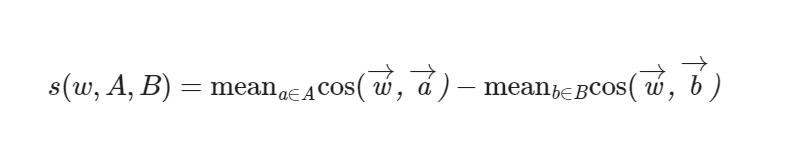

In [9]:
Image(filename='./data/s.png') 

In [7]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

#### WEAT score 함수

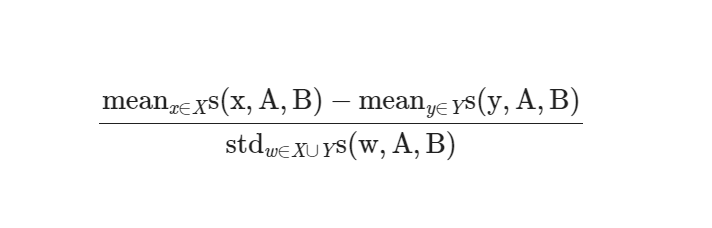

In [10]:
Image(filename='./data/weat_score.png') 

In [8]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


* X = 예술영화(art)
* Y = 일반영화(gen)  


In [74]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [80]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [81]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.49271214
SF 공연 -0.38479036
SF 공포(호러) -0.6684208
SF 기타 0.3369339
SF 다큐멘터리 0.5710849
SF 드라마 -0.37180683
SF 멜로로맨스 -0.7864046
SF 뮤지컬 0.33296397
SF 미스터리 -0.6807212
SF 범죄 -0.23329894
SF 사극 -0.8305285
SF 서부극(웨스턴) -0.43043423
SF 성인물(에로) -0.5745926
SF 스릴러 -0.5221983
SF 애니메이션 0.35209507
SF 액션 -0.4377844
SF 어드벤처 -0.78089696
SF 전쟁 0.20468955
SF 코미디 -0.44147357
SF 판타지 -0.18104038
가족 공연 0.16113189
가족 공포(호러) -0.17109253
가족 기타 0.72451323
가족 다큐멘터리 0.8021763
가족 드라마 0.2015392
가족 멜로로맨스 -0.6293828
가족 뮤지컬 0.67521864
가족 미스터리 -0.31830165
가족 범죄 0.19055374
가족 사극 -0.103462294
가족 서부극(웨스턴) 0.35951713
가족 성인물(에로) -0.34096017
가족 스릴러 -0.15811914
가족 애니메이션 0.83163494
가족 액션 0.10181001
가족 어드벤처 -0.054906514
가족 전쟁 0.6248422
가족 코미디 0.1864347
가족 판타지 0.4123713
공연 공포(호러) -0.23323421
공연 기타 0.9018858
공연 다큐멘터리 0.90032923
공연 드라마 0.02531057
공연 멜로로맨스 -0.68822646
공연 뮤지컬 0.86109734
공연 미스터리 -0.34561884
공연 범죄 0.07707789
공연 사극 -0.36636811
공연 서부극(웨스턴) 0.032236643
공연 성인물(에로) -0.48001873
공연 스릴러 -0.21423456
공연 애니메이션 0.89382493
공연 액션 

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

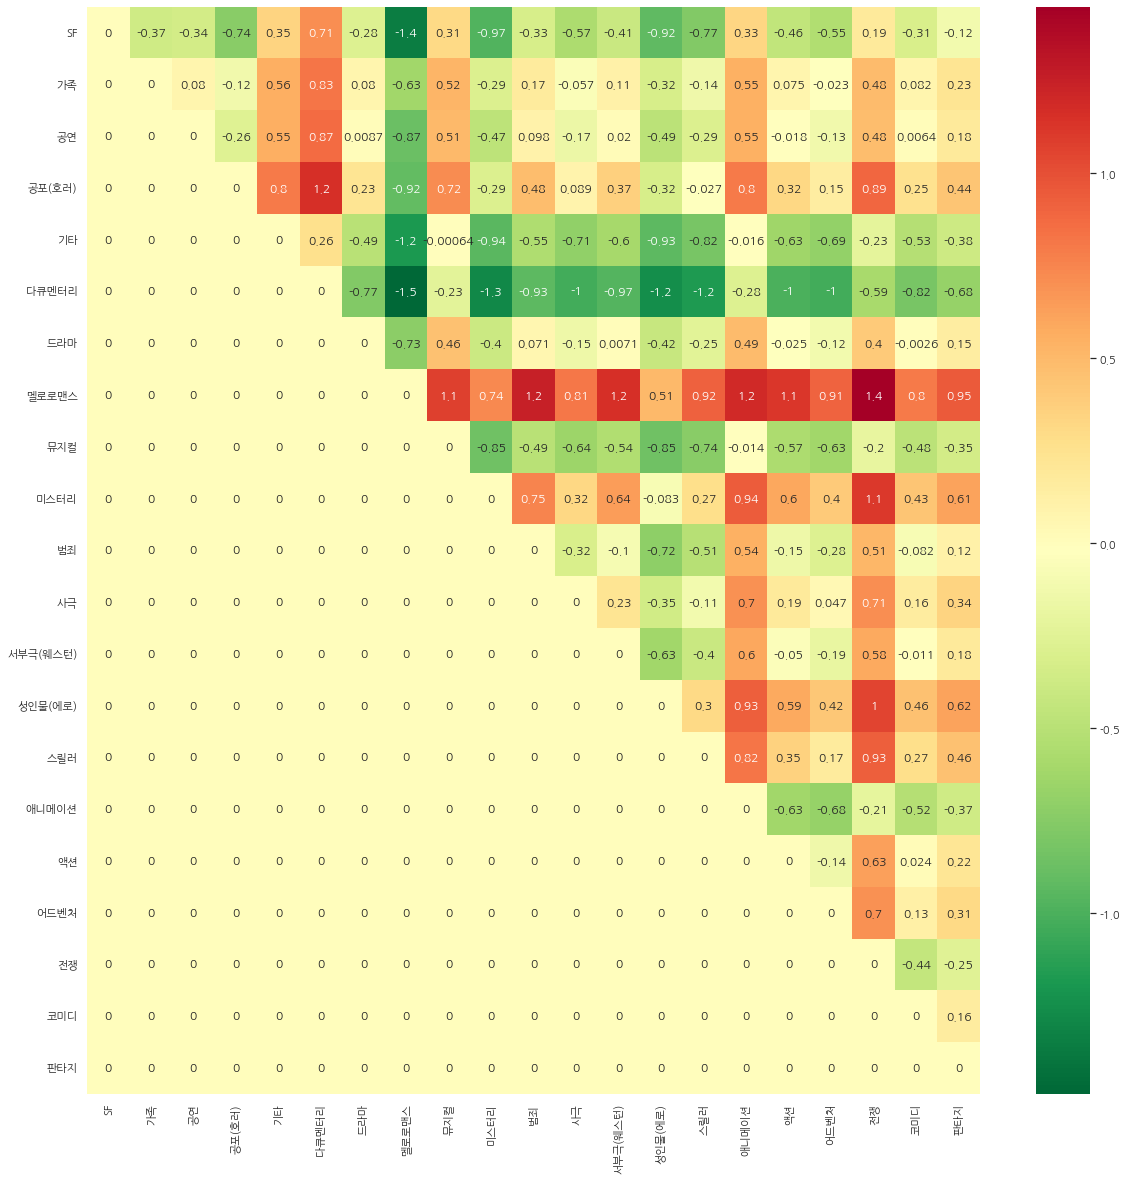

In [77]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

plt.figure(figsize=(20,20))
# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

#### WEAT score 0.8 이상 ( 부호가 +이므로 사람의 편향과 같음)

In [96]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] >= 0.8 : 
            print(genre_name[i], genre_name[j],matrix[i][j])

가족 다큐멘터리 0.8021763
가족 애니메이션 0.83163494
공연 기타 0.9018858
공연 다큐멘터리 0.90032923
공연 뮤지컬 0.86109734
공연 애니메이션 0.89382493
드라마 애니메이션 0.8588032
멜로로맨스 뮤지컬 0.8387149
멜로로맨스 범죄 0.8363175
멜로로맨스 애니메이션 0.85699844
멜로로맨스 코미디 0.89184076
멜로로맨스 판타지 0.8211771
미스터리 범죄 0.9876824
사극 애니메이션 0.8211613
사극 전쟁 0.8586076


|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|가족|다큐멘터리|같음|0.80 |
|가족|애니메니션|같음|0.83 |
|공연|기타|같음| 0.90|
|공연|다큐멘터리|같음|0.90 |
|공연|뮤지컬|같음|0.86 |
|공연|애니메이션|같음|0.89 |
|드라마|매니메이션|같음|0.85 |
|멜로로맨스|뮤지컬|같음|0.83 |
|멜로로맨스|범죄|같음|0.83 |
|멜로로맨스|애니메이션|같음|0.85 |
|멜로로맨스|코미디|같음|0.89 |
|멜로로맨스|판타지|같음|0.82 |
|미스터리|범죄|같음|0.98 |
|사극|애미메이션|같음|0.82 |
|사극|전쟁|같음|0.85 |

#### WEAT score - 0.8 이하 ( 부호가 -이므로 사람의 편향과 반대임)

In [94]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] <= -0.8 : 
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 사극 -0.8305285
기타 드라마 -0.85781413
기타 멜로로맨스 -0.8704546
기타 사극 -0.8095894
기타 성인물(에로) -0.80475205
다큐멘터리 드라마 -0.8835549
다큐멘터리 멜로로맨스 -0.87523586
다큐멘터리 사극 -0.8793625
다큐멘터리 성인물(에로) -0.8179707
다큐멘터리 어드벤처 -0.92290896
다큐멘터리 판타지 -0.86301374
드라마 멜로로맨스 -0.82414144
범죄 스릴러 -0.97473246
애니메이션 어드벤처 -0.87322026


|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|사극|SF|반대|-0.83 |
|드라마|기타|반대|-0.85 |
|멜로로맨스|기타|반대| -0.87|
|사극|기타|반대|-0.80 |
|성인물|기타|반대|-0.88 |
|드라마|다큐멘터리|반대|-0.87 |
|멜레로맨스|타큐멘터리|반대|-0.87 |
|사극|다큐멘터리|반대|-0.81 |
|성인물|다큐멘터리|반대|-0.92 |
|에드밴처|다큐멘터리|반대|-0.86 |
|판타지|드라마|반대|-0.82 |
|멜로로맨스|판타지|반대|-0.97 |
|스릴러|범죄|반대|0.98 |
|애니메이션|애미메이션|반대|-0.87 |

## 회고 

 **1. 사람의 편향과 반대**
 
|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|사극|SF|반대|-0.83 |
|드라마|기타|반대|-0.85 |
|멜로로맨스|기타|반대| -0.87|
|사극|기타|반대|-0.80 |
|성인물|기타|반대|-0.88 |
|드라마|다큐멘터리|반대|-0.87 |
|멜레로맨스|타큐멘터리|반대|-0.87 |
|사극|다큐멘터리|반대|-0.81 |
|성인물|다큐멘터리|반대|-0.92 |
|에드밴처|다큐멘터리|반대|-0.86 |
|판타지|드라마|반대|-0.82 |
|멜로로맨스|판타지|반대|-0.97 |
|스릴러|범죄|반대|0.98 |
|애니메이션|애미메이션|반대|-0.87 |
  
<hr/>

 **2. 사람의 편향과 같음** 
 
|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|가족|다큐멘터리|같음|0.80 |
|가족|애니메니션|같음|0.83 |
|공연|기타|같음| 0.90|
|공연|다큐멘터리|같음|0.90 |
|공연|뮤지컬|같음|0.86 |
|공연|애니메이션|같음|0.89 |
|드라마|매니메이션|같음|0.85 |
|멜로로맨스|뮤지컬|같음|0.83 |
|멜로로맨스|범죄|같음|0.83 |
|멜로로맨스|애니메이션|같음|0.85 |
|멜로로맨스|코미디|같음|0.89 |
|멜로로맨스|판타지|같음|0.82 |
|미스터리|범죄|같음|0.98 |
|사극|애미메이션|같음|0.82 |
|사극|전쟁|같음|0.85 |